In [12]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [13]:
(train_data, val_data), info = tfds.load('ag_news_subset:1.0.0', #version 1.0.0
                                         split=['train[:90%]', 'train[90%:]+test'],
                                         with_info=True,
                                         as_supervised=True
)

In [14]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided by the academic comunity for research
    purposes in data mining (clustering, classification, etc), information retrieval
    (ranking, search, etc), xml, data compression, data streaming, and any other
    non-commercial activity. For more information, please refer to the link
    http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang
    (xiang.zhang@nyu.edu) from the dataset above. It is used as a text
    classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann
    LeCu

In [15]:
# Displaying the classes

class_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print(f'The news are grouped into {num_classes} classes that are :{class_names}')

The news are grouped into 4 classes that are :['World', 'Sports', 'Business', 'Sci/Tech']


In [16]:
num_train = info.splits['train'].num_examples
num_val = info.splits['test'].num_examples

print(f'The number of training samples: {num_train} \nThe number of validation samples: {num_val}')

The number of training samples: 120000 
The number of validation samples: 7600


In [17]:
news_df = tfds.as_dataframe(train_data.take(10), info)

news_df.head(10)

,description,label
0,b'AMD #39;s new dual-core Opteron chip is desi...,3
1,b'Reuters - Major League Baseball\\Monday anno...,1
2,b'President Bush #39;s quot;revenue-neutral q...,2
3,b'Britain will run out of leading scientists u...,3
4,"b'London, England (Sports Network) - England m...",1
5,b'TOKYO - Sony Corp. is banking on the \\$3 bi...,0
6,b'Giant pandas may well prefer bamboo to lapto...,3
7,"b'VILNIUS, Lithuania - Lithuania #39;s main pa...",0
8,b'Witnesses in the trial of a US soldier charg...,0
9,"b'Dan Olsen of Ponte Vedra Beach, Fla., shot a...",1


In [18]:
for i in range (0,4):

  print(f"Sample news {i}\n \
  Label: {news_df['label'][i]} {(class_names[i])}\n \
  Description: {news_df['description'][i]}\n----------\n")

Sample news 0
   Label: 3 World
   Description: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
----------

Sample news 1
   Label: 1 Sports
   Description: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
----------

Sample news 2
   Label: 2 Business
   Description: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
----------

Sample news 3
   Label: 3 Sci/Tech
   Description: b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'
----------



# **Preparing the data..**

In [19]:
buffer_size = 1000
batch_size = 32

train_data = train_data.shuffle(buffer_size)
train_data = train_data.batch(batch_size).prefetch(1)
val_data = val_data.batch(batch_size).prefetch(1)

In [20]:
for news, label in train_data.take(1):

  print(f'Sample news\n----\n {news.numpy()[:4]} \n----\nCorresponding labels: {label.numpy()[:4]}')

Sample news
----
 [b'NEW YORK -- Evander Holyfield knows that life, like boxing, is about adjustments. On Saturday night, we will see whether he has made the biggest adjustment of his career -- the adjustment to a boxing life of diminished skills.'
 b'Australia #39;s  #39;Mr Soccer #39; Johnny Warren has announced he will be visiting Tumut later this month as part of his tireless campaign to promote the world game at grass roots level.'
 b'New York Attorney General Eliot Spitzer on Friday filed suit against Universal Life Resources (ULR), charging the life and disability insurance broker with taking fraudulent kick-backs for steering business to certain insurers.'
 b' NEW YORK (Reuters) - U.S. stocks were little changed on  Thursday after a report showed a larger-than-expected rise in  weekly jobless claims, but a continued drop in oil prices  boosted investor sentiment.'] 
----
Corresponding labels: [1 1 2 2]


In [21]:
max_features = 10000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features)

In [23]:
text_vectorizer.adapt(train_data.map(lambda description, label : description))

In [24]:
vocab = text_vectorizer.get_vocabulary()
vocab[:10]

['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for']

In [25]:
sample_news = ['This weekend there is a sport match between Man U and Fc Barcelona',
               'Tesla has unveiled its humanoid robot that appeared dancing during the show!']



In [26]:
vectorized_news = text_vectorizer(sample_news)
vectorized_news.numpy()

array([[  40,  494,  186,   16,    3, 1567,  570,  159,  370,    1,    7,
        7486, 2556],
       [   1,   20,  876,   13,    1, 4845,   10, 1273,    1,  160,    2,
         532,    0]])

# **Creating and Training the Model...**

In [27]:
input_dim = len(text_vectorizer.get_vocabulary())
input_dim

10000

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),
    tf.keras.layers.Masking(),  # Explicitly handle masking
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ masking (Masking)                    │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,300 (2.61 MB)

 Trainable params: 683,300 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

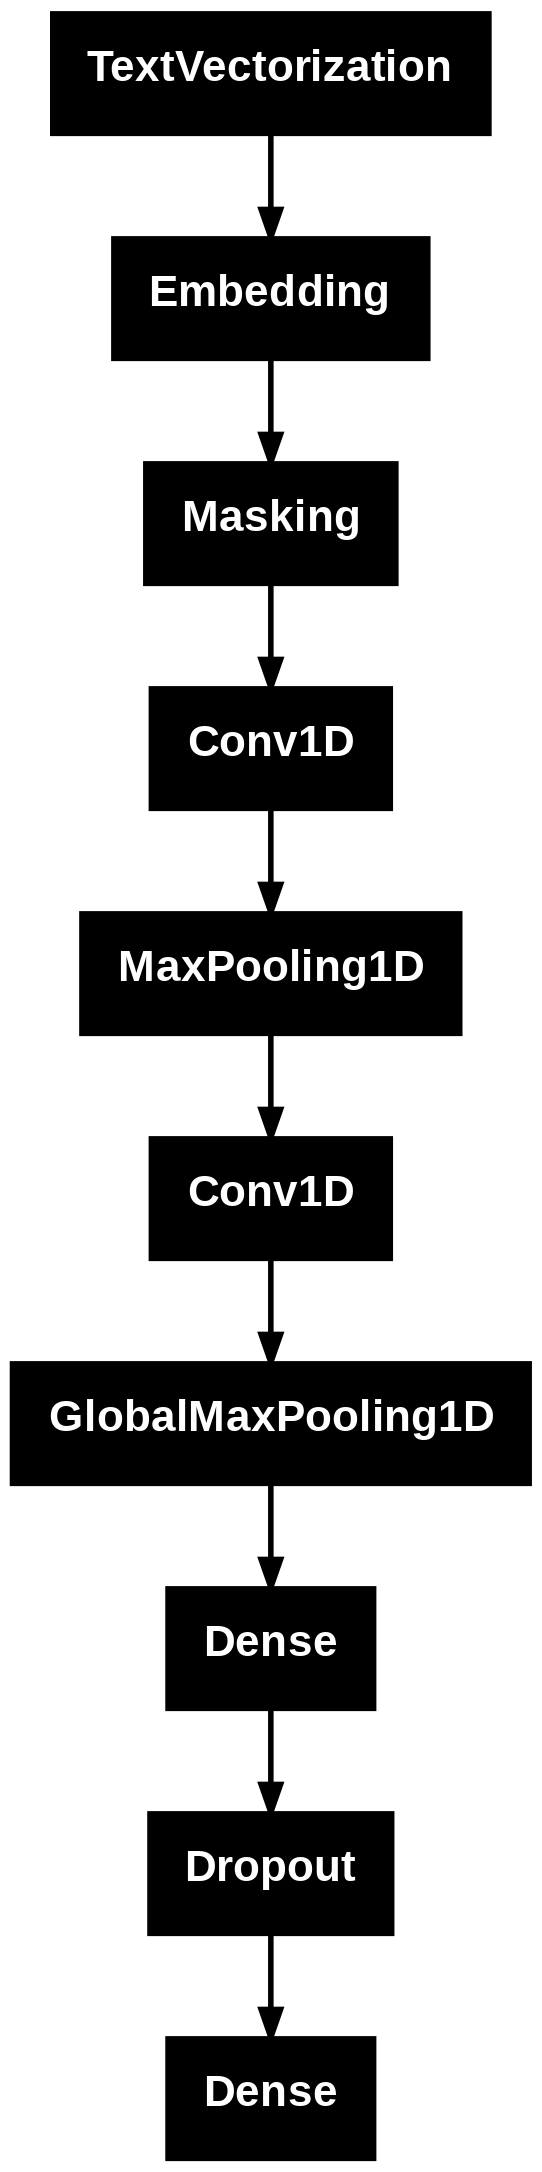

In [30]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [31]:
# Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)

In [33]:
# Train the model

history = model.fit(train_data,
                    epochs=25,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.2656 - loss: 1.3788 - val_accuracy: 0.5000 - val_loss: 1.0855
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5345 - loss: 0.9970 - val_accuracy: 0.8174 - val_loss: 0.5528
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7825 - loss: 0.6185 - val_accuracy: 0.8454 - val_loss: 0.4750
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8256 - loss: 0.5326 - val_accuracy: 0.8536 - val_loss: 0.4268
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8492 - loss: 0.4343 - val_accuracy: 0.8684 - val_loss: 0.4043
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8481 - loss: 0.4578 - val_accuracy: 0.8684 - val_loss: 0.3997
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8749 - loss: 0.4020 - val_accuracy: 0.8865 - val_loss: 0.3723
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8669 - loss: 0.4166 - val_accuracy: 0.873

# **Visualizing the Results..**

In [34]:
import matplotlib.pyplot as plt

# function to plot accuracy and loss

def plot_acc_loss(history):

  model_history = history.history
  acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']
  loss = model_history['loss']
  val_loss = model_history['val_loss']
  epochs = history.epoch

  plt.figure(figsize=(10,5))
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)

  # Create a new figure with plt.figure()
  plt.figure()

  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()

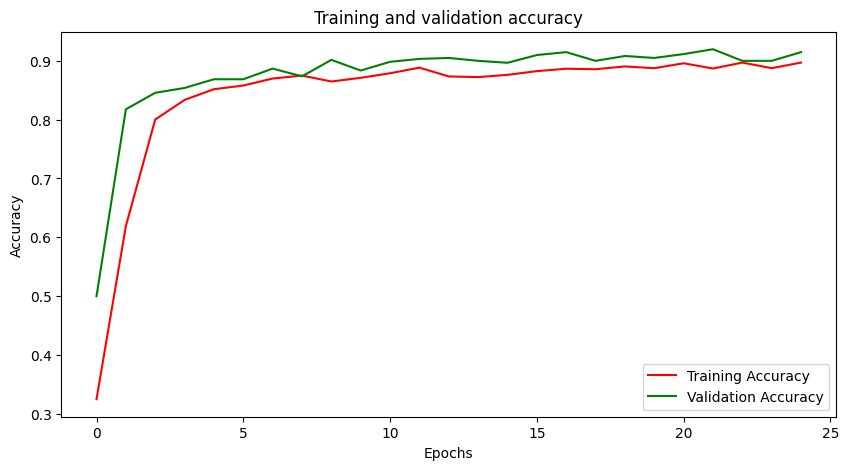

<Figure size 640x480 with 0 Axes>

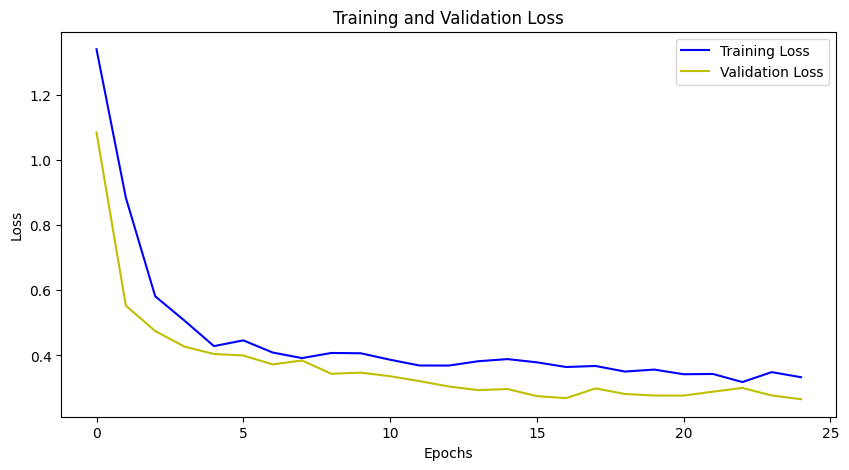

In [35]:
plot_acc_loss(history)

# **Combining CNNs and RNNs for Text Classification..**

In [36]:
conv_rnn_model = tf.keras.Sequential([
    # Input layer for text data
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),

    # Text vectorization layer
    text_vectorizer,  # Ensure text_vectorizer is pre-defined and configured

    # Embedding layer
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),

    # Convolutional layers
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),

    # Bidirectional LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Fully connected layers
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes in the target output
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [37]:
conv_rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, None, 64)            │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,396 (2.87 MB)

 Trainable params: 751,396 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compile the model

conv_rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)


# Train the model

history = conv_rnn_model.fit(train_data,
                    epochs=25,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.2780 - loss: 1.3564 - val_accuracy: 0.6299 - val_loss: 0.8543
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6623 - loss: 0.8373 - val_accuracy: 0.8125 - val_loss: 0.5624
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8014 - loss: 0.5885 - val_accuracy: 0.8487 - val_loss: 0.4346
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8363 - loss: 0.4904 - val_accuracy: 0.8569 - val_loss: 0.4352
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8486 - loss: 0.4579 - val_accuracy: 0.8651 - val_loss: 0.4144
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8433 - loss: 0.4678 - val_accuracy: 0.8701 - val_loss: 0.3685
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8593 - loss: 0.4420 - val_accuracy: 0.8783 - val_loss: 0.3604
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8807 - loss: 0.3865 - val_ac

# **Visualizing the Results...**

# **Testing the Model, giving new articles and classifying it...**

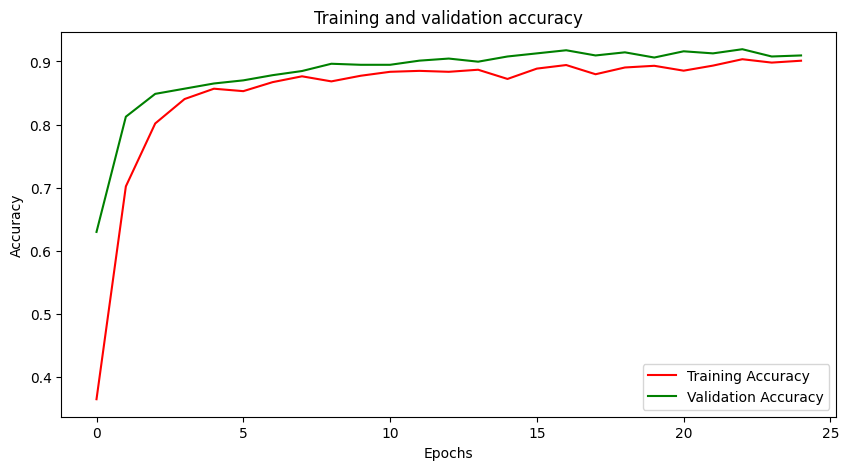

<Figure size 640x480 with 0 Axes>

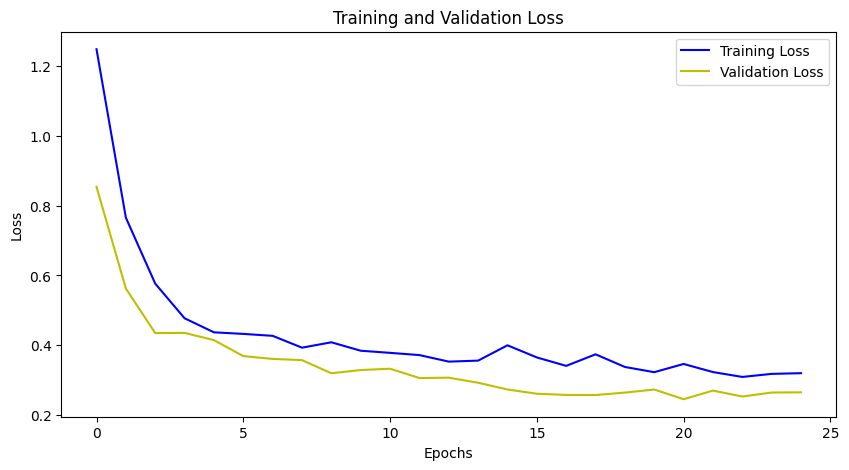

In [40]:
plot_acc_loss(history)

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, log_loss, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [49]:
y_true, y_pred, y_prob = [], [], []

for news_batch, label_batch in val_data:
    predictions = conv_rnn_model.predict(news_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    y_prob.extend(predictions)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

In [50]:
#Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

       World       0.94      0.86      0.90      4985
      Sports       0.92      0.98      0.95      4915
    Business       0.89      0.84      0.86      4819
    Sci/Tech       0.84      0.90      0.87      4881

    accuracy                           0.90     19600
   macro avg       0.90      0.89      0.89     19600
weighted avg       0.90      0.90      0.89     19600



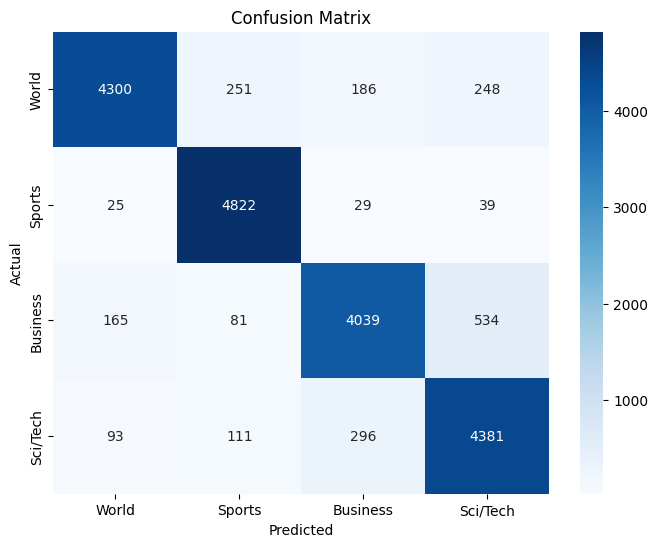

In [52]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [53]:
#Accuracy Score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.4f}")

Accuracy Score: 0.8950


In [54]:
#ROC-AUC Score (macro-averaged for multi-class)
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
print(f"ROC-AUC Score (OvR): {roc_auc:.4f}")

ROC-AUC Score (OvR): 0.9794


In [56]:
#Log Loss
print(f"Log Loss: {log_loss(y_true, y_prob):.4f}")

Log Loss: 0.3102


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


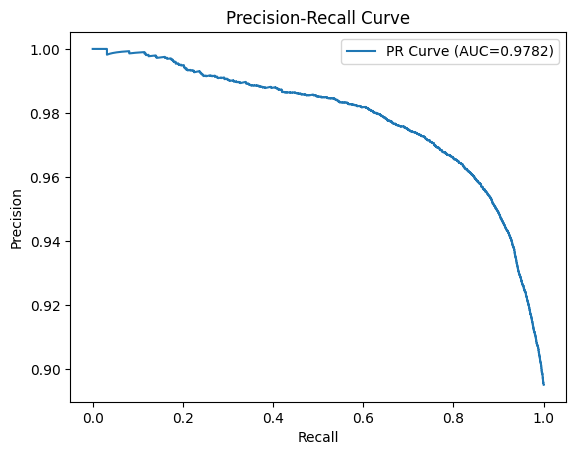

In [57]:
#Precision-Recall Curve (micro-average)
precision, recall, _ = precision_recall_curve(np.array(y_true) == np.array(y_pred), np.max(y_prob, axis=1))
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'PR Curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [41]:
def predict(model, sample_news, class_names):

    # Ensure the input is a TensorFlow constant with correct dtype
    sample_news = tf.constant(sample_news, dtype=tf.string)

    # Predict the news type
    preds = model.predict(sample_news)

    # Retrieve and display predictions
    for i, pred in enumerate(preds):
        pred_class = np.argmax(pred)
        print(f"Sample {i+1}:")
        print(f"  Predicted Class Index: {pred_class}")
        print(f"  Predicted Class Name: {class_names[pred_class]}\n")


In [42]:
sample_news = ['Tesla, a self driving car company is also planning to make a humanoid robot. This humanoid robot appeared dancing in the latest Tesla AI day']

predict(conv_rnn_model, sample_news, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
Sample 1:
  Predicted Class Index: 3
  Predicted Class Name: Sci/Tech



In [43]:
sample_news = ["In the last weeks, there has been many transfer suprises in footbal. Ronaldo went back to Old Trafford, "
                "while Messi went to Paris Saint Germain to join his former colleague Neymar."
                "We can't wait to see these two clubs will perform in upcoming leagues"]


predict(conv_rnn_model, sample_news, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sample 1:
  Predicted Class Index: 1
  Predicted Class Name: Sports



In [44]:
sample_news = ["In the latest business news: The tech giant NVIDIA has acquired ARM, a microproccessor company"]


predict(conv_rnn_model, sample_news, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sample 1:
  Predicted Class Index: 3
  Predicted Class Name: Sci/Tech



In [45]:
sample_news = ["Cricketer Virat Kohli scored his maiden century at Lords Stadium today at England, Great Britain"]
predict(conv_rnn_model, sample_news, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sample 1:
  Predicted Class Index: 1
  Predicted Class Name: Sports



In [46]:
sample_news = ["Apple has just unveiled its latest iPhone, featuring a new A-series processor and an upgraded camera system."]


predict(conv_rnn_model, sample_news, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sample 1:
  Predicted Class Index: 3
  Predicted Class Name: Sci/Tech



In [47]:
sample_news= ["Roger Federer won his 100th tennis game, fans cheer for him at greater oval venue United States"]
predict(conv_rnn_model, sample_news, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Sample 1:
  Predicted Class Index: 1
  Predicted Class Name: Sports

